In [12]:
# 绘制DWS 和 resolvability  model
import pygmt 
import xarray as xr 
import pandas as pd 
import numpy as np
import glob
import os

In [13]:
resname = '3'
model = xr.open_dataset('TGR_data'+os.sep+'tomoDD09'+os.sep+f'TGR_2009_checkerboard_{resname}_19.h5')
model = model.where(model.depth <= 10,drop=True)
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')
stations = pd.read_csv('TGR_data/tomoDD09/ph2dt/station.dat',sep='\s+',names=['name','latitude','longitude','elevation'])


In [14]:
lons,lats = model.longitude.values,model.latitude.values
dx,dy = np.diff(lons)[0],np.diff(lats)[0]
dx,dy = 0,0
region = [lons[0]-dx/2,lons[-1]+dx/2,lats[0]-dy/2,lats[-1]+dy/2]
idx_lon,idx_lat = np.searchsorted(lons,110+24/60),np.searchsorted(lats,31+5/60)
clon,clat = lons[idx_lon],lats[idx_lat]

# 插值
dx=dy=0.1
lons,lats = model.longitude.values,model.latitude.values
new_lons = np.linspace(lons[0],lons[-1],10*len(lons))
new_lats = np.linspace(lats[0],lats[-1],10*len(lats))
#model = model.interp(longitude=new_lons,latitude=new_lats)

In [15]:
def plot_slice(fig,depth=1,wv_type='dwsp',interval=2,cmap='res.cpt',label=None):
    reloc = catalog[(catalog.depth >= depth-0.5)&(catalog.depth<=depth+0.5)]
    data = model.sel(depth=depth)
    grid_dws = data[wv_type]
    if wv_type[0:3] == 'dws':
        grid_dws = np.log10(grid_dws+1.0)
    fig.grdimage(grid=grid_dws,cmap=cmap)
    fig.plot(data='TGR_data/geology/Faults.gmt',pen='0.3p,gray17')
    # plot the rivers
    #fig.plot(data='TGR_data/geology/HYDA.gmt',pen='0.1p,0/112/255',fill='0/112/255',close=True,transparency=30)
    #fig.plot(data='TGR_data/geology/Rivers.gmt',pen='0.5p,0/112/255',close=False,transparency=50) # Yangtze river
    fig.plot(data='TGR_data/geology/TGR.shp',pen='0.1p,0/112/255',fill='0/112/255',close=False,transparency=50)

    fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.02i',fill='white',pen='0.1p')
    fig.plot(x=stations.longitude,y=stations.latitude,style='t0.2c',fill='black',pen='0.1p,black')
    fig.grdcontour(grid=grid_dws,interval=interval,limit=[interval,interval],pen='0.7p,black',label=label)
    fig.text(position='cBR',text=f'{depth} km',offset='-0.1c/0.1c',fill='white')


In [16]:
pygmt.makecpt(cmap='seis',series=[-5,5,0.1],continuous=True,reverse=True,background=True,output='dws.cpt')
pygmt.makecpt(cmap='seis',series=[0.5-0.7,0.5+0.7,0.05],continuous=True,reverse=True,background=True,output='res.cpt')

pygmt.makecpt(cmap='polar',series=[-5,5,0.1],continuous=True,reverse=False,background=True,output='dws.cpt')
pygmt.makecpt(cmap='jet',series=[0.5-0.7,0.5+0.7,0.05],continuous=True,reverse=True,background=True,output='res.cpt')

pygmt.makecpt(cmap='gray',series=[0,5,0.1],continuous=True,reverse=True,background=True,output='dws.cpt')
pygmt.makecpt(cmap='gray',series=[0.5,1.2,0.05],continuous=True,reverse=True,background=True,output='res.cpt')

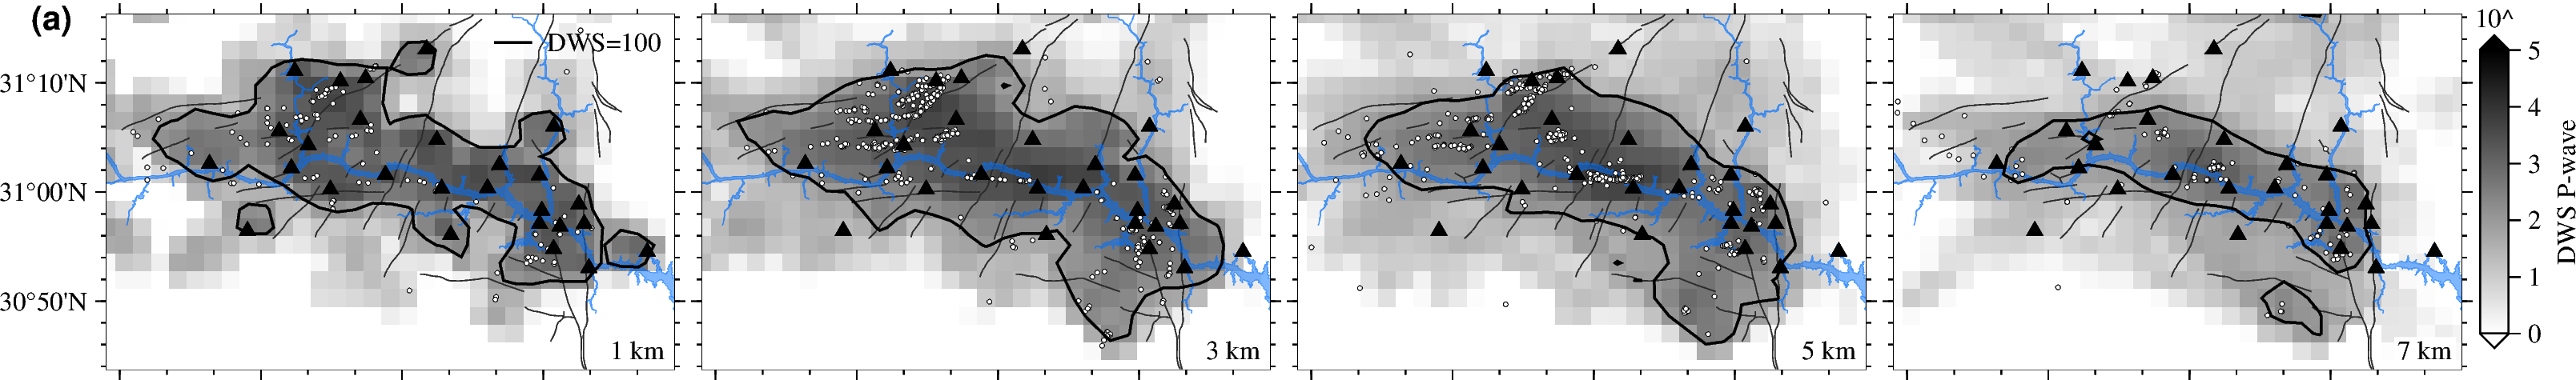

In [17]:
fig = pygmt.Figure()
map_width = 6
depths,ty = [1,3,5,7],'main'
#depths,ty = [2,4,6,8],'S'
interval,label = np.log10(100),'DWS=100'
intervalr,labelr = 0.7,'RES=0.7' 
pygmt.config(FONT='8p,4',COLOR_NAN='128',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','Wsen'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)
plot_slice(fig,depth=depths[0],wv_type='dwsp',interval=interval,cmap='dws.cpt',label=label)
fig.legend(position='jTR')
fig.text(position='cTL',text='(a)',font='10p,1',offset='j-0.8c/-0.1c',fill='white',no_clip=True)

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[1],wv_type='dwsp',interval=interval,cmap='dws.cpt')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[2],wv_type='dwsp',interval=interval,cmap='dws.cpt')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[3],wv_type='dwsp',interval=interval,cmap='dws.cpt')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xa1f+lDWS P-wave','y+l10^'],cmap='dws.cpt',truncate=[0,5])

fig.show()

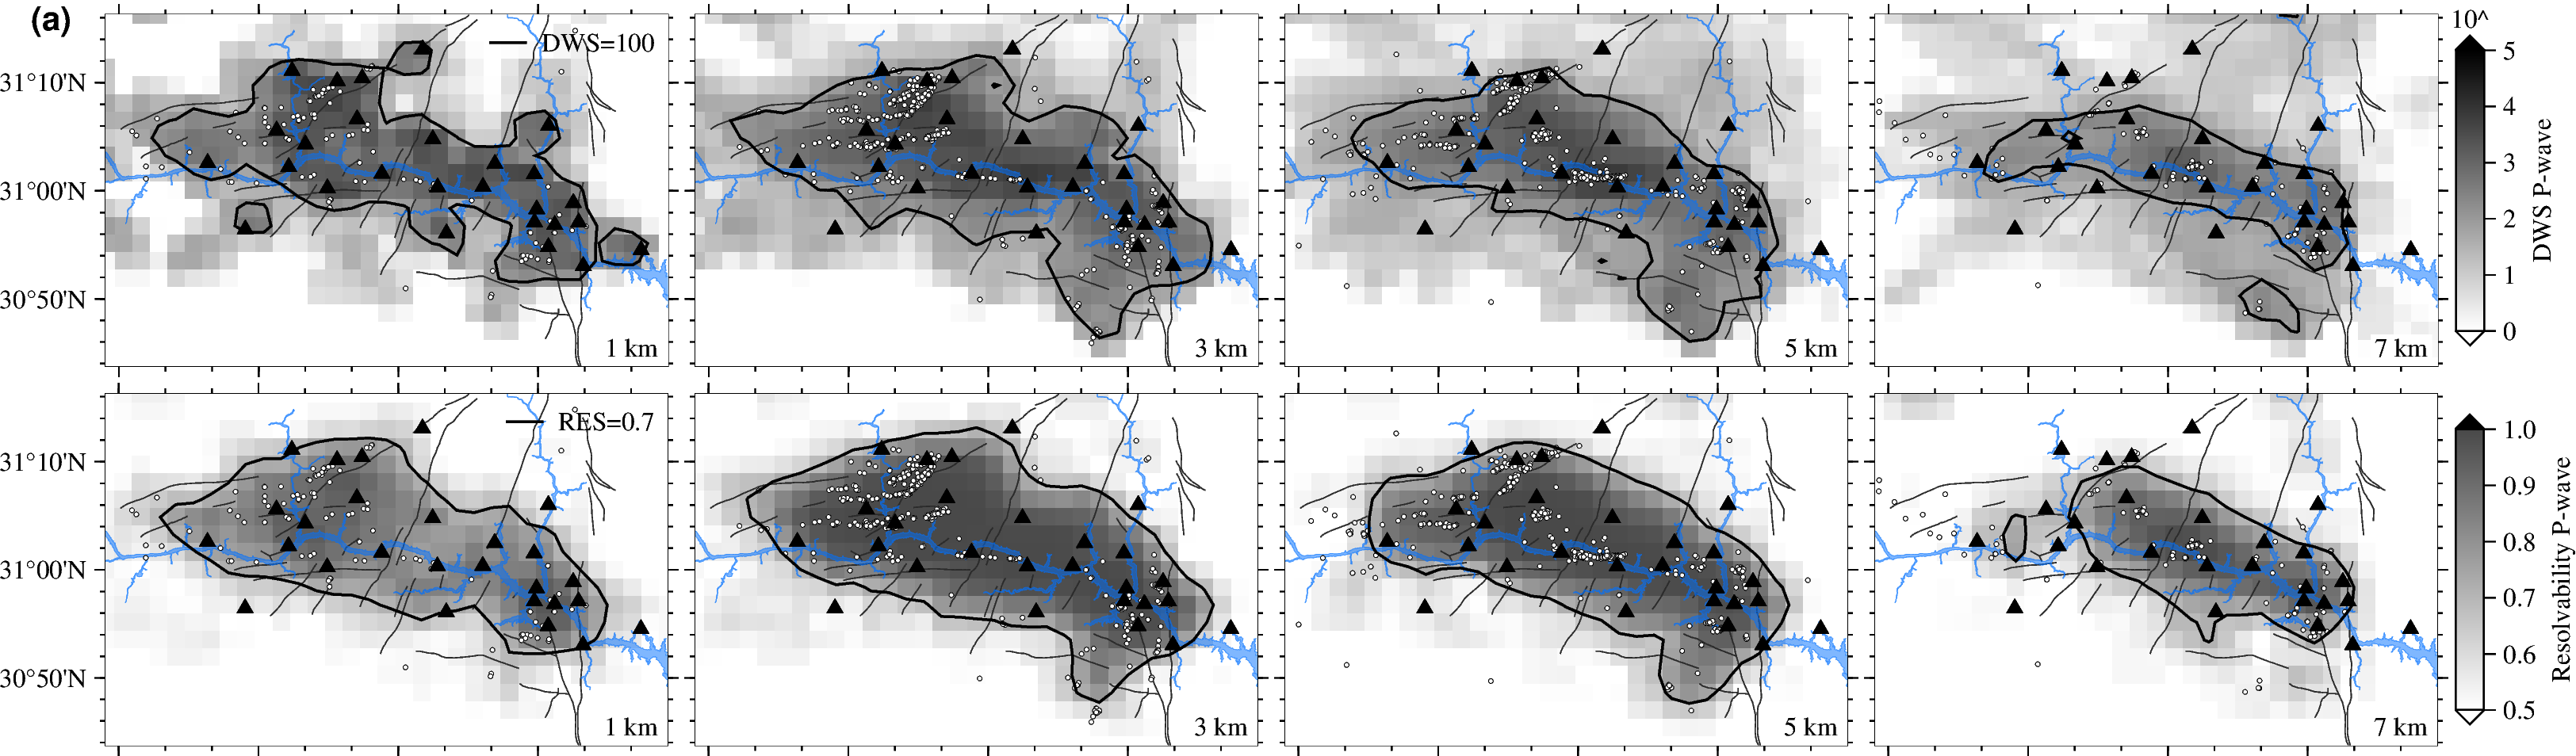

In [18]:
fig.shift_origin(xshift=f"-{(map_width+0.3)*3}c",yshift=f"-{map_height+0.3}c")
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','Wsen'])
plot_slice(fig,depth=depths[0],wv_type='res_p',interval=0.7,cmap='res.cpt',label='RES=0.7')
fig.legend(position='jTR')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[1],wv_type='res_p',interval=0.7,cmap='res.cpt')


fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[2],wv_type='res_p',interval=0.7,cmap='res.cpt')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[3],wv_type='res_p',interval=0.7,cmap='res.cpt')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xa0.1f+lResolvability P-wave'],cmap='res.cpt',truncate=[0.5,1.0])

fig.show()

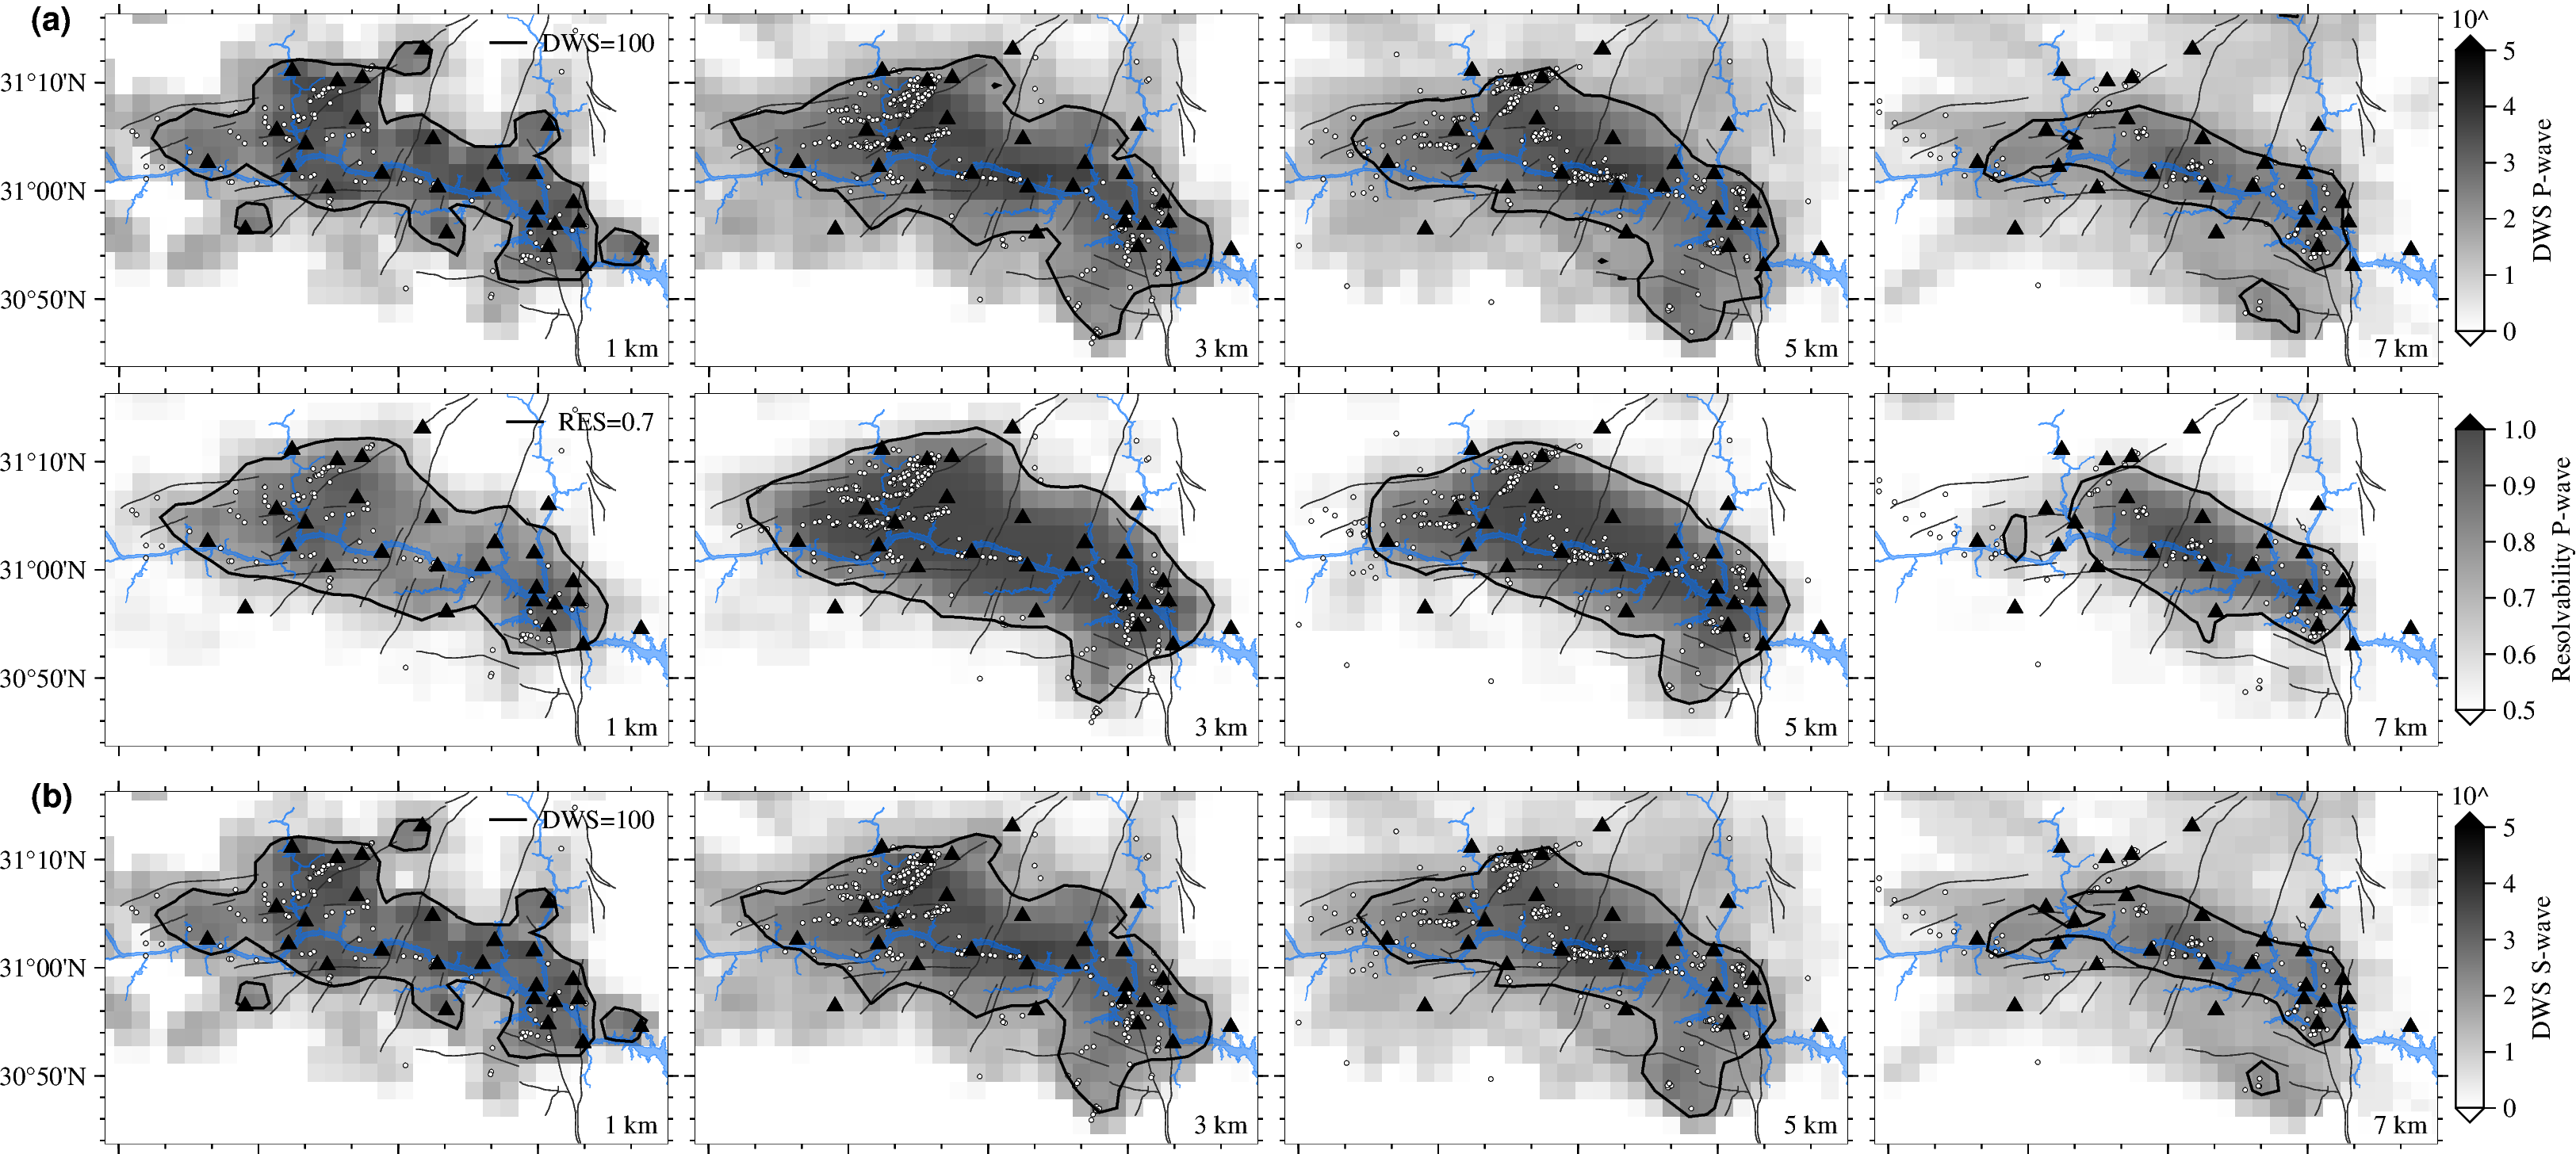

In [19]:
# plot S-wave
fig.shift_origin(xshift=f"-{(map_width+0.3)*3}c",yshift=f"-{map_height+0.5}c")
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','Wsen'])
plot_slice(fig,depth=depths[0],wv_type='dwss',interval=interval,cmap='dws.cpt',label=label)
fig.legend(position='jTR')
fig.text(position='cTL',text='(b)',font='10p,1',offset='j-0.8c/-0.1c',fill='white',no_clip=True)

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[1],wv_type='dwss',interval=interval,cmap='dws.cpt')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[2],wv_type='dwss',interval=interval,cmap='dws.cpt')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wsen'])
plot_slice(fig,depth=depths[3],wv_type='dwss',interval=interval,cmap='dws.cpt')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xa1f+lDWS S-wave','y+l10^'],cmap='dws.cpt',truncate=[0,5])

fig.show()

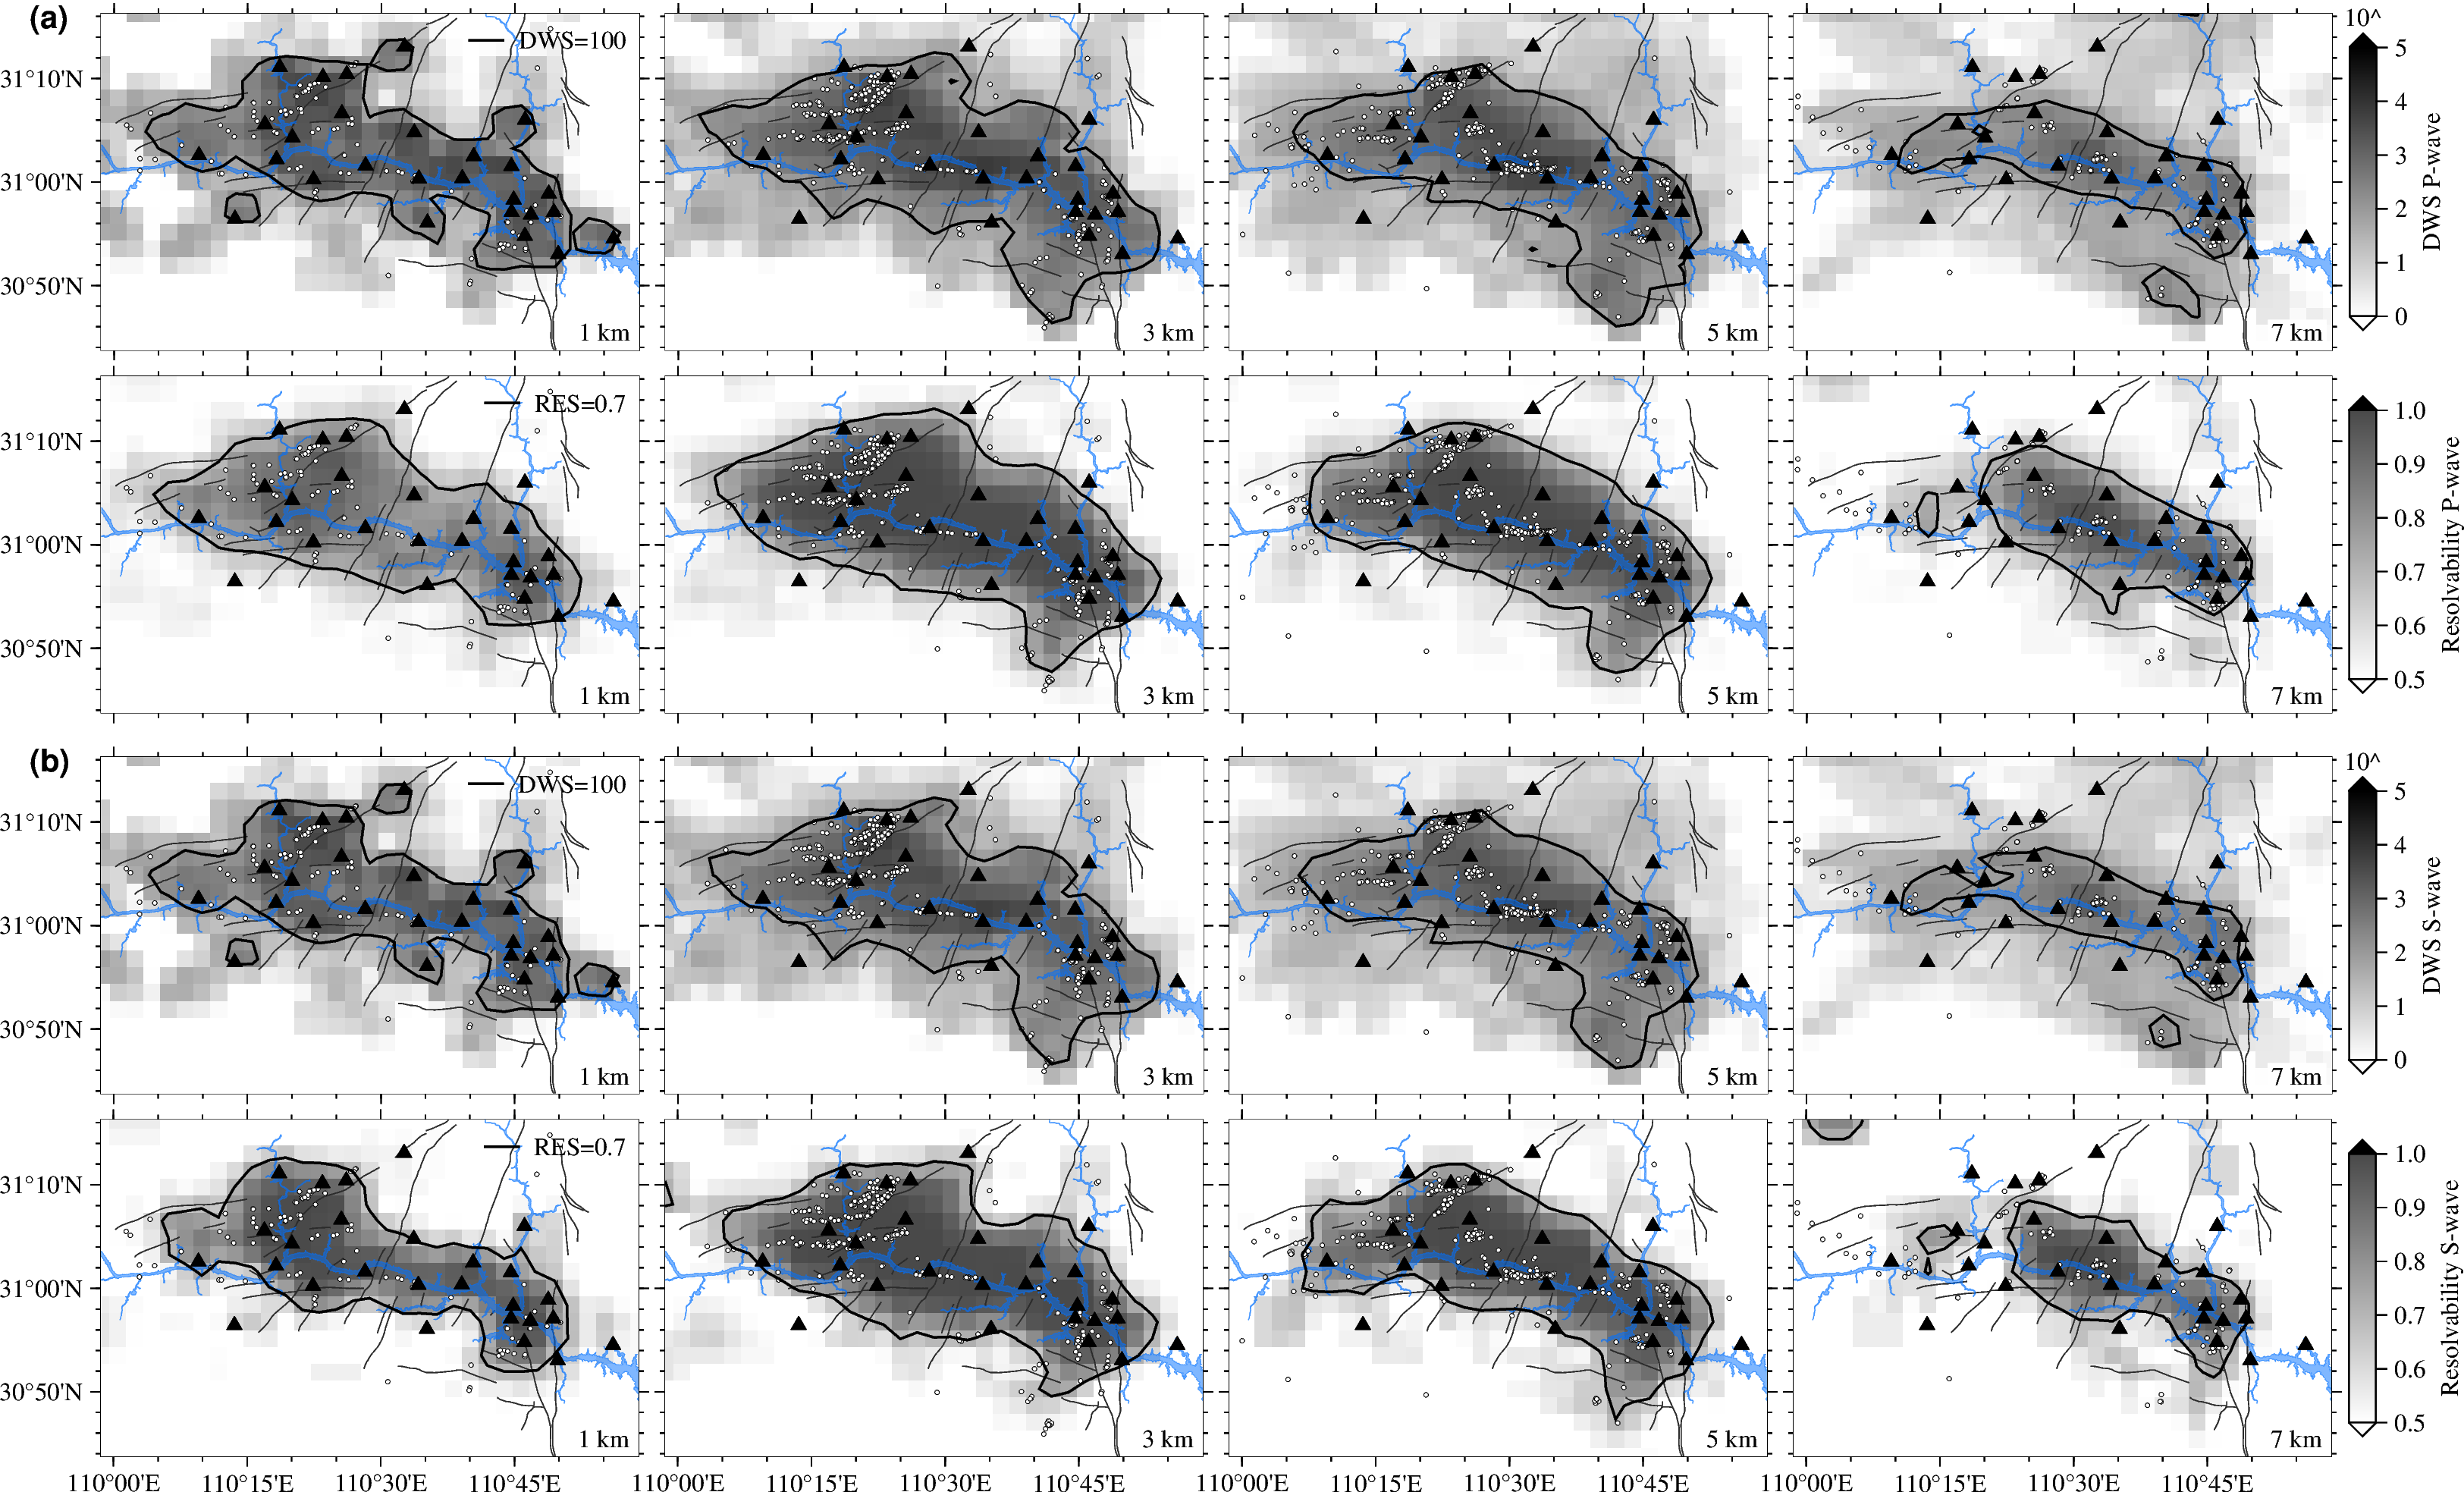

In [20]:
fig.shift_origin(xshift=f"-{(map_width+0.3)*3}c",yshift=f"-{map_height+0.3}c")
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','WSen'])
plot_slice(fig,depth=depths[0],wv_type='res_s',interval=0.7,cmap='res.cpt',label='RES=0.7')
fig.legend(position='jTR')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wSen'])
plot_slice(fig,depth=depths[1],wv_type='res_s',interval=0.7,cmap='res.cpt')


fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wSen'])
plot_slice(fig,depth=depths[2],wv_type='res_s',interval=0.7,cmap='res.cpt')

fig.shift_origin(xshift=f'{map_width+0.3}c')
fig.basemap(region=region,projection=f'M{map_width}c',frame=['xaf','yaf','wSen'])
plot_slice(fig,depth=depths[3],wv_type='res_s',interval=0.7,cmap='res.cpt')
fig.colorbar(position='JMR+w0c/0.3c+o0.2c/0c+e',frame=['xa0.1f+lResolvability S-wave'],cmap='res.cpt',truncate=[0.5,1.0])

fig.show()

In [21]:
fig.savefig(f'plotting_figures/Figure9_{ty}_dws_res.png',dpi=600)
fig.savefig(f'plotting_figures/Figure9_{ty}_dws_res.pdf')

In [22]:
# remove data
for file in glob.glob('*.cpt'):
    os.remove(file)